In [1]:
%load_ext autoreload
%autoreload 2

Le code dans la cellule ci-dessus permet de créer un "écran virtuel" pour que ``gym`` puisse faire le rendu des environnements.
Cela est nécessaire si on souhaite exécuter le code sur un serveur distant ou dans un container Docker.

L'écran virtuel est créé avec ``Xvfb``. Il faut mettre l'option ``visible=False`` pour que ça fonctionne avec ``Xvfb``.

In [2]:
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

Doc de stable_baselines3 : https://stable-baselines3.readthedocs.io/en/master/guide/install.html

**Attention :** stable_baselines utilise Tensorflow. **stable_baselines3 utilise PyTorch**
```bash
# En root
# xvfb permet de créer un "écran virtuel". Cela est nécessaire pour faire un rendu vidéo
# sur la plupart des environnements de Gym (par exemple, ceux de Classic Control).
# Il n'y a pas besoin de xvfb sur les jeux Atari.
apt update && apt install -y cmake libopenmpi-dev python3-dev zlib1g-dev swig python-opengl xvfb
pip3 install stable_baselines3 stable_baselines3[extra] gym[box2d] pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
# Open source implementation of Mujoco env provided by gym : pybullet-gym
git clone https://github.com/benelot/pybullet-gym.git
cd pybullet-gym
pip install -e .
```

In [2]:
import os
import gym
import itertools
# L'import ci-dessous est nécessaire si on souhaite utiliser des environnements similaires
# à MuJoCo mais OpenSource, basé sur pybullet
import pybulletgym

import torch
import numpy as np
import matplotlib.pyplot as plt

from gym.wrappers import TimeLimit
from stable_baselines3 import SAC

from src.model import DIAYN, Buffer
from src.utils import image_to_bytes, Displayer

from tqdm.auto import tqdm, trange


from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

Pour accéder aux différents environnements de Gym, voir la page suivante : https://github.com/openai/gym/wiki/Table-of-environments

In [3]:
params = dict(
    n_skills = 5,
    total_timesteps = 10_000,
    hidden_dim = 32,
    lr = 1E-3
)

ENV = "Pendulum-v0"
#ENV = "MountainCarContinuous-v0"

env = gym.make(ENV).env
env = TimeLimit(env, max_episode_steps=50)
env = DIAYN(env, **params)

  0%|          | 0/10000 [00:00<?, ?it/s]

Il faut créer le dossier ``tensorboard`` pour avoir les logs de l'actor et du critic.

In [4]:
agent = SAC("MlpPolicy", env, verbose=0, batch_size=64, tensorboard_log="./tensorboard", ent_coef=0.1)
agent.learn(total_timesteps=params["total_timesteps"])

In [5]:
losses = [i.item() for i in env.discriminator_losses]

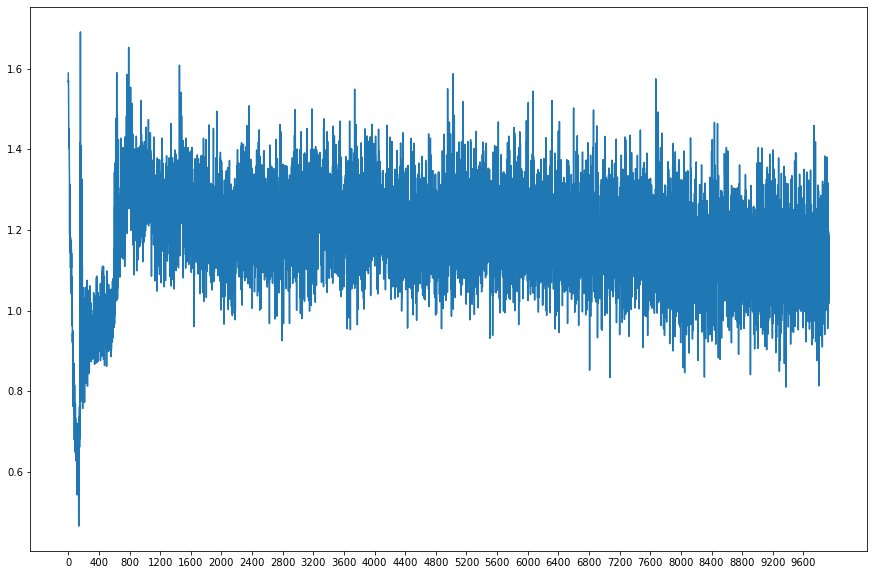

In [6]:
plt.figure(figsize=(15,10))
plt.plot(losses)
plt.xticks(np.arange(0, params["total_timesteps"], 400));

In [8]:
video = Displayer()
display(video.image)

Image(value=b'', layout="Layout(align_items='center', border='solid', display='flex', flex_flow='row', justify…

In [9]:
env_test = gym.make(ENV).env
env_test = TimeLimit(env_test, max_episode_steps=200)
env_test = DIAYN(env_test, params["n_skills"])

for skill in trange(params["n_skills"]):
    done = False

    env_test.skill = skill
    obs = env_test.reset()
        
    while not done:
        action, _states = agent.predict(obs, deterministic=True)

        obs, reward, done, info = env_test.step(action)
        
        frame = Image.fromarray(env_test.render(mode='rgb_array'))
        video.image.value = image_to_bytes(frame)

  0%|          | 0/5 [00:00<?, ?it/s]